In [ ]:
# run this cell if using colab
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/mm_nn/methods /content/
!cp -r /content/drive/MyDrive/mm_nn/train.h5 /content/
!cp -r /content/drive/MyDrive/mm_nn/test.h5 /content/
!cp -r /content/drive/MyDrive/mm_nn/params.yaml /content/

# !pip install -U "ray[tune]"
# !pip install wandb

In [1]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm.notebook import tqdm
from datetime import datetime

from methods.base import BaseConfig
from methods.plotting import plot_perm, plot_press, plot_event_list, plot_events_projection

import os
from pathlib import Path

CURR_DIR = os.getcwd()
train_h5_path = f'{CURR_DIR}/train.h5'
test_h5_path = f'{CURR_DIR}/test.h5'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


c:\!Work\Projects\nn_for_mm\.venv\Lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = 'cpu'  # if needed

### Data retrieving example

Permeability map


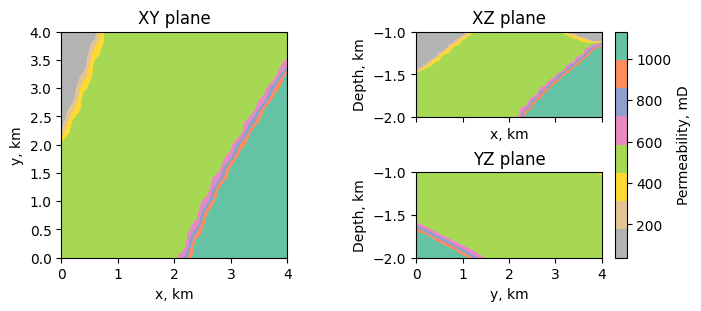

Pore pressure at the fimal step


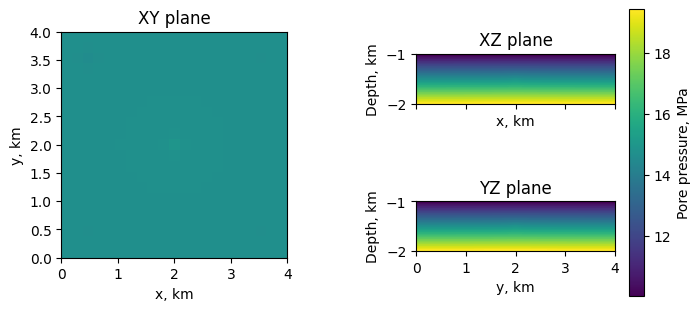

Events
Seismic density at the fimal step


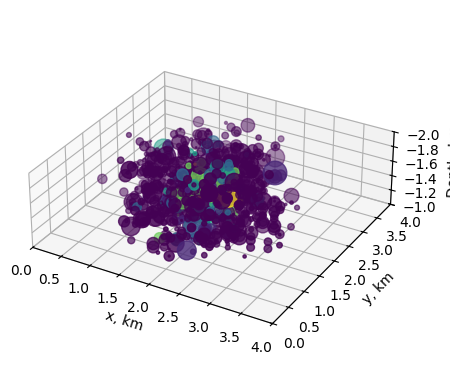

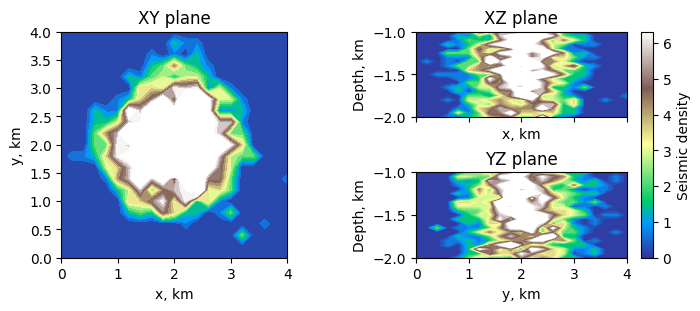

Pore pressure at the fimal step at source location slice


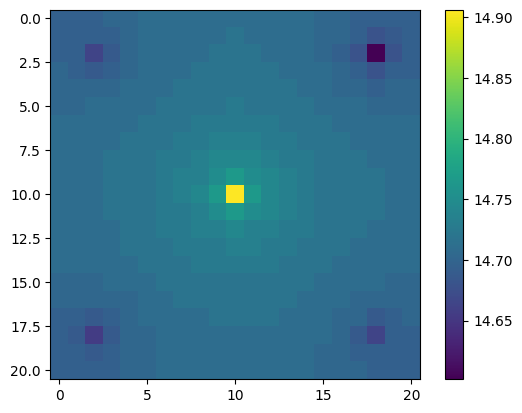

In [3]:
jj = 42 

with h5py.File(train_h5_path, 'a') as f:
    ev = f['events'][jj]
    pp = f['perm'][jj]
    pore = f['pore'][jj]
    ev_d = f['ev_dens'][jj]

params = BaseConfig()
params.load() # loading params from params.yaml

print('Permeability map')
plot_perm(pp, loc=(10, 10, 10), params=params)

print('Pore pressure at the fimal step')
plot_press(pore, loc=(10, 10, 10), params=params)

print('Events')
plot_event_list(ev[0:900], params=params)

print('Seismic density at the fimal step')
plot_events_projection(ev_d, params=params)

print('Pore pressure at the fimal step at source location slice')
fig, ax = plt.subplots()
ims = ax.imshow(pore[:,:,10]) # pore press at source location slice
plt.colorbar(ims, ax=ax)

#### dataset class

In [4]:
# Dataset Class
class EventsToPermDataset(torch.utils.data.Dataset):

    def __init__(self, h5_path, transforms):
        super().__init__()
        self.path = h5_path
        self.transforms = self.stack_transforms(transforms) # transforms func
        with h5py.File(h5_path, 'a') as f:
            nmodels = f['events'].shape[0]
        self.nmodels = nmodels

    def __getitem__(self, idx):
        with h5py.File(self.path, 'a') as f:
            event = f['events'][idx]
            perm = f['perm'][idx]

        return self.transforms(event, perm)

    def __len__(self):
        return self.nmodels

    def stack_transforms(self, func_list):
        def performer(*args):
            for f in func_list:
                args = f(*args)
            return args
        return performer

class Normalizer:
    ''' returns log10(perm)     '''
    def __call__(self, events, perms):
        log_perm = torch.log10(perms)
        return events, log_perm

class ToTensor:
    '''Transforms numpy to torch tensors'''
    def __call__(self, events, perms):
        perms = torch.Tensor(perms)
        events = torch.Tensor(events)
        return events, perms

#### model

In [5]:
class EventListTransformerEncoder(nn.Module):
    '''
    Performs attention over the List of events
    '''
    def __init__(self, emb_size, num_layers, nheads):
        super().__init__()
        self.emb_size = emb_size
        self.num_layers = num_layers
        self.nheads = nheads
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = self.emb_size, nhead = self.nheads, batch_first=True) # one head. emb size is unpredictable
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return x

class Fc(nn.Module):
    '''
    universal Fc layer inp_size - > target size via num_layers
    '''
    def __init__(self, inp_size, target_size, num_layers, fc_drop):
        super().__init__()
        self.target_size = target_size
        self.layers = self.create_layers(inp_size, target_size, num_layers)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(fc_drop)

    def create_layers(self, inp, outp, nlayers):
        mult = (outp/inp)**(1/nlayers)
        sizes = [int(inp*mult**ii) for ii in range(nlayers)]
        sizes.append(outp)
        layers = [nn.Linear(sizes[ii], sizes[ii+1]) for ii in range(nlayers)]
        return nn.ModuleList(layers)

    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.flatten(0, 1)
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))
        x = self.layers[-1](x)
        x = x.view(bs, -1, self.target_size)
        return x


class EventsToPerm(nn.Module):
    '''
    Model itself
    list of events -> permeability map
    '''
    def __init__(self, params):
        super().__init__()
        self.inp_size = params.input_shape[-1] # 5
        self.emb_size = params.emb_size # 5 to
        self.target_shape = params.target_shape # (21, 21, 21)
        self.target_size = np.prod(self.target_shape).item() # over 9000

        self.embed = Fc(inp_size = self.inp_size, target_size = self.emb_size, num_layers = params.embed_num_layers, fc_drop = 0)
        self.encoder = EventListTransformerEncoder(emb_size = self.emb_size, num_layers = params.encoder_num_layers, nheads = params.nheads)
        self.fc = Fc(inp_size = self.emb_size, target_size = self.target_size, num_layers = params.fc_num_layers, fc_drop = 0.1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.embed(x)
        x = self.encoder(x)
        x = self.fc(x)
        x = torch.mean(x, -2)
        x = x.view(bs, *self.target_shape)
        return x
    
#----------------------- upconv things -----------------------------
    
class Upconv(nn.Module):
    '''
    universal Fc layer inp_size - > target size via num_layers
    '''
    def __init__(self, event_num, small_cube_side, target_shape):
        super().__init__()
        self.small_cube_side = small_cube_side
        self.event_num = event_num
        self.target_shape = target_shape
        self.relu = nn.ReLU()

        # self.upconv_1 = nn.ConvTranspose3d(self.event_num, 64, 3, 2, 1, output_padding=1)
        # self.upconv_2 = nn.ConvTranspose3d(64, 64, 3, 2, 1, output_padding=1)
        # self.upconv_3 = nn.ConvTranspose3d(64, 1, 3, 2, 1, output_padding=1)
        self.upconv_1 = nn.ConvTranspose3d(self.event_num, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, dilation=1)
        self.upconv_2 = nn.ConvTranspose3d(64, 64, kernel_size = 3, stride = 2,  padding = 1, output_padding = 0)
        self.upconv_3 = nn.ConvTranspose3d(64, 1, kernel_size = 3, stride = 2,  padding = 1, output_padding = 0)


    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.view(bs, -1, self.small_cube_side, self.small_cube_side, self.small_cube_side) # small cubes
        x = self.relu(self.upconv_1(x))
        x = self.relu(self.upconv_2(x))
        x = self.upconv_3(x)
        x = x.squeeze(1)
        return x
    
class EventsToPermUpconv(nn.Module):
    '''
    Model itself
    list of events -> permeability map
    '''
    def __init__(self, params):
        super().__init__()
        self.inp_size = params.input_shape[1] # 5
        self.event_num = params.input_shape[0]
       
        self.small_cube_side = params.small_cube_side
        self.emb_size = self.small_cube_side ** 3
        self.target_shape = params.target_shape # (21, 21, 21)

        self.embed = Fc(inp_size = self.inp_size, target_size = self.emb_size, num_layers = params.embed_num_layers, fc_drop = 0)
        self.encoder = EventListTransformerEncoder(emb_size = self.emb_size, num_layers = params.encoder_num_layers, nheads = params.nheads)
        self.upconv = Upconv(event_num = self.event_num,  small_cube_side = self.small_cube_side, target_shape = self.target_shape)

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        x = self.upconv(x)
        return x

In [6]:
upconv_1 = nn.ConvTranspose3d(1200, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, dilation=1)
upconv_2 = nn.ConvTranspose3d(64, 64, kernel_size = 3, stride = 2,  padding = 1, output_padding = 0)
upconv_3 = nn.ConvTranspose3d(64, 1, kernel_size = 3, stride = 2,  padding = 1, output_padding = 0)

a = torch.ones(10, 1200, 3,3,3)

b = upconv_1(a)
print(b.shape)
b = upconv_2(b)
print(b.shape)
b = upconv_3(b)
print(b.shape)

b = b.squeeze(1)
print(b.shape)


torch.Size([10, 64, 6, 6, 6])
torch.Size([10, 64, 11, 11, 11])
torch.Size([10, 1, 21, 21, 21])
torch.Size([10, 21, 21, 21])


#### net class

In [7]:
class PermNet:
    def __init__(self, train_h5_path, test_h5_path, train_params):
        self.params = train_params
        self.device = self.params.device
        self.train_dl, self.test_dl = self.create_dl(train_h5_path, test_h5_path)
        # self.model = EventsToPerm(self.params)
        self.model = EventsToPermUpconv(self.params)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params.lr)
        self.loss = torch.nn.MSELoss(reduction='mean')

    def __call__(self, X):
        self.model.to(self.device).eval()
        X = X.to(self.device)
        with torch.no_grad():
            y_hat = self.model(X).cpu()
        self.model.to("cpu")
        return y_hat

    def evaluate(self):
        val_loss = []
        self.model.to(self.device).eval()
        for X, y in self.test_dl:
            X, y = X.to(self.device), y.to(self.device)
            with torch.no_grad():
                y_hat = self.model(X)
            l = self.loss(y_hat, y)
            val_loss.append(l.item())
        self.model.to("cpu")
        return torch.mean(torch.tensor(val_loss)).item()

    def train(self):
        self.metrics = {'loss':{'train': [], 'val': []}, 'epoch': []}
        for epoch in tqdm(range(self.params.epochs)):
            losses = self.train_one_epoch()
            # wandb.log(losses) # wandb here
            self.metrics['epoch'].append(epoch)
            self.metrics['loss']['train'].append(losses['train'])
            self.metrics['loss']['val'].append(losses['val'])
            if epoch % 1 == 0:
                print(f"Epoch {epoch}:: train loss: {self.metrics['loss']['train'][-1]:.04f}, val loss: {self.metrics['loss']['val'][-1]:.04f}")
        return self.metrics

    def train_one_epoch(self):
        self.model.to(self.device).train()
        for X, y in tqdm(self.train_dl):
            X, y = X.to(self.device), y.to(self.device)
            y_hat = self.model(X)
            l = self.loss(y_hat, y)
            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()
        losses = {'train': l.item(), 'val': self.evaluate()}
        self.model.to("cpu")
        return losses

    def create_dl(self, train_h5_path, test_h5_path):
        # creates dataloaders
        transforms = [ToTensor(), Normalizer(),] # data transformations

        train = EventsToPermDataset(h5_path = train_h5_path, transforms=transforms)
        test = EventsToPermDataset(h5_path = test_h5_path, transforms=transforms)

        # this is for testing
        # train = torch.utils.data.Subset(train, torch.randperm(2000).tolist())

        train_dl = DataLoader(dataset=train,
                            batch_size=self.params.batch_size,
                            shuffle=True,
                            )

        test_dl = DataLoader(dataset=test,
                            batch_size=self.params.batch_size,
                            shuffle=False,
                            )

        return train_dl, test_dl

    def plot_metrics(self):
        fig, ax = plt.subplots(figsize=(4.33, 3))
        ax.plot(self.metrics['epoch'], self.metrics['loss']['train'], label='train')
        ax.plot(self.metrics['epoch'], self.metrics['loss']['val'],  label='val')
        ax.set_title('Loss', loc='center', fontsize=12)
        ax.set_xlabel('# Epoch', fontsize=12)
        ax.legend()

    def print_summary(self):
        print(summary(self.model, input_size=(1,) + self.params.input_shape))
        

    def get_weights(self):
        return self.model.state_dict()

    def set_weights(self, state_dict):
        self.model.load_state_dict(state_dict)

    def load_weights(self, pt_path):
        self.model.load_state_dict(torch.load(pt_path)) #, map_location=torch.device(self.device)))

    def save(self, state_name=''):
        Path(f'{CURR_DIR}/model_states/').mkdir(parents=True, exist_ok=True)
        pt_path = f'{CURR_DIR}/model_states/{state_name}{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.pt'
        torch.save(self.model.state_dict(), pt_path)

#### params for training class

In [8]:
class TrainConfig:
    def __init__(self, **kwargs):
        # default model params
        self.input_shape = (1100, 5)
        self.target_shape = (21, 21, 21)

        # embed layer params
        self.embed_num_layers = 3

        # small cube
        self.small_cube_side = 3

        # encoder params
        # self.emb_size = 21
        self.encoder_num_layers = 10
        self.nheads = 1

        # fc params
        self.fc_num_layers = 5

        # default training params
        self.batch_size = 10
        self.epochs = 2
        self.lr = 0.0001

        # device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # kwargs to attrs
        self.__dict__.update(kwargs)

    def __repr__(self) -> str:
        return str(self.__dict__)

#### training procedure

In [9]:
train_params = TrainConfig(epochs=1)
net = PermNet(train_h5_path, test_h5_path, train_params)
net.train()
net.plot_metrics()

# net.save()
# !cp -r /content/model_states/ /content/drive/MyDrive/mm_nn/

c:\!Work\Projects\nn_for_mm\.venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### it works?

In [13]:
train_params = TrainConfig(epochs=1)
net = PermNet(train_h5_path, test_h5_path, train_params)
net.load_weights('05_27_2024__18_12_34.pt')

c:\Users\Nikopol\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
net.print_summary()

Layer (type:depth-idx)                             Output Shape              Param #
EventsToPermUpconv                                 [1, 21, 21, 21]           --
├─Fc: 1-1                                          [1, 1100, 27]             --
│    └─ModuleList: 2-7                             --                        (recursive)
│    │    └─Linear: 3-1                            [1100, 8]                 48
│    └─ReLU: 2-2                                   [1100, 8]                 --
│    └─Dropout: 2-3                                [1100, 8]                 --
│    └─ModuleList: 2-7                             --                        (recursive)
│    │    └─Linear: 3-2                            [1100, 15]                135
│    └─ReLU: 2-5                                   [1100, 15]                --
│    └─Dropout: 2-6                                [1100, 15]                --
│    └─ModuleList: 2-7                             --                        (recursive)
│    │ 

Ground truth Permeability map


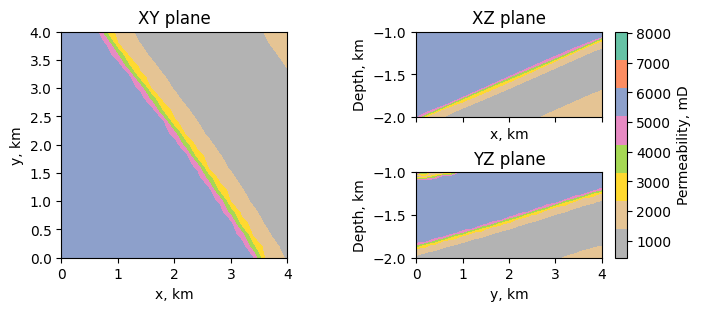

Model Permeability map


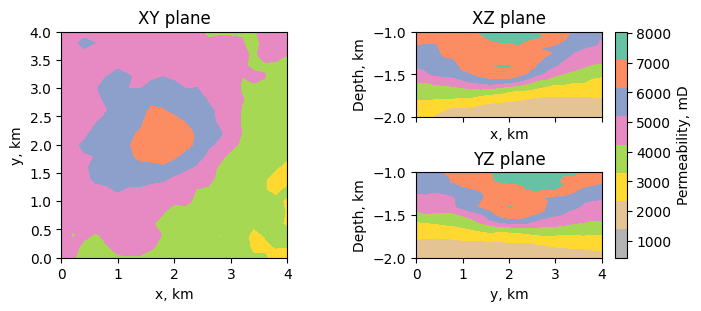

In [9]:
jj = 300

transforms = [ToTensor(), Normalizer(),] # data transformations
test = EventsToPermDataset(h5_path = test_h5_path, transforms=transforms)

x, y = test[jj]

y = y.numpy()
x = x.unsqueeze(0)
y_hat = net(x).squeeze(0).detach().numpy()

params = BaseConfig()
params.load() # loading params from params.yaml

vmin_vmax = (10**np.min(np.minimum(y, y_hat)), 10**np.max(np.maximum(y, y_hat))) # for same norms

print('Ground truth Permeability map')
plot_perm(10**y, loc=(10, 10, 10), params=params, vmin_vmax=vmin_vmax)

print('Model Permeability map')
plot_perm(10**y_hat, loc=(10, 10, 10), params=params, vmin_vmax=vmin_vmax)

  0%|          | 0/198 [00:00<?, ?it/s]

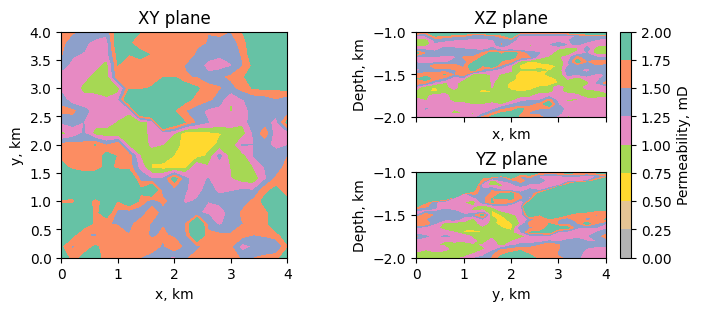

In [11]:
num = 5
# how good is it
all_dk_k_mean = 0
for ii, (X, y) in enumerate(tqdm(net.test_dl)):
    y_hat = net(X).squeeze(0).detach().numpy()
    y = y.numpy()
    dk_k = np.abs(10**y-10**y_hat)/10**y
    dk_k_mean =np.mean(dk_k, axis=0)
    # dk_k_std =np.std(dk_k, axis=0)

    all_dk_k_mean += dk_k_mean
    if ii==num:
        break

# all_dk_k_mean = all_dk_k_mean/net.test_dl.__len__()
all_dk_k_mean = all_dk_k_mean/num

params = BaseConfig()
params.load()
plot_perm(all_dk_k_mean, loc=(10, 10, 10), params=params, vmin_vmax=(0,2))
